# Task

My task in this project is to predict the type of attack terrorists will engage in using data from the Global Terrorism Database (GTD). This task replicates the work of Huamani et al (2020), where the authors use machine learning data to predict the possible attack types such as hijackings, bombings and kindnapping. I will try to improve upon their results. This is a multi-class classification task.

Link to paper: https://pdfs.semanticscholar.org/91db/4ac3c85a515e0e921e0b6e71960212049ae3.pdf

Note: The database is large with over 135 columns. I have attached a codebook which you can also find here for detailed feature descriptions. https://www.start.umd.edu/gtd/downloads/Codebook.pdf

# Import Packages

In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
import util
from util import FeatureImportance
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re

In [2]:
#Global variable to use for later
target_names = ["Assassination",
                "Armed Assault",
                "Bombing/Explosion",
                "Hijacking",
                "Barricade Incident",
                "Kidnapping",
                "Facility/Infrastructure Attack",
                "Unarmed Assault"]

# Part 1: Data Preprocessing

In [3]:
gtd = pd.read_csv("globalterrorismdb_0221dist.csv")

C:\Users\thiya\AppData\Local\Temp\ipykernel_3304\4257334231.py:1: DtypeWarning: Columns (4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  gtd = pd.read_csv("globalterrorismdb_0221dist.csv")


In [3]:
gtd.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [4]:
len(gtd)

201183

My data has 201,183 rows and 135 columns. I received a warning message stating that there are mixed types in specific data columns. I will have to clean the data to address this issue.

In [24]:
gtd.iloc[:, [4,31,33,54,61,62,63,76,79,90,92,94,96,114,115,121]]

,approxdate,attacktype2_txt,attacktype3_txt,corp3,gsubname2,gname3,gsubname3,claimmode2_txt,claimmode3_txt,weaptype3_txt,weapsubtype3_txt,weaptype4_txt,weapsubtype4_txt,divert,kidhijcountry,ransomnote
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201178,"December 31, 2019",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201180,"December 31, 2019",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These are the columns I have received warnings about. I will have to clean the na values in these columns.

## 1.1 Sampling

### Subsetting Dataset

In [4]:
#subset data where region != NaN
gtd = gtd.loc[gtd["attacktype1"] != 9]

Since I am predicting attack types, I must subset the data to exclude any rows where the target is an na value.

In [5]:
len(gtd)

191593

I am left with 191,953 rows.

There are 8 types of attacks terrorists carry out


Bombing/Explosion                      95402
Armed Assault                          47419
Assassination                          20897
Hostage Taking (Kidnapping)            13198
Facility/Infrastructure Attack         11636
Unarmed Assault                         1183
Hostage Taking (Barricade Incident)     1124
Hijacking                                734
Name: attacktype1_txt, dtype: int64

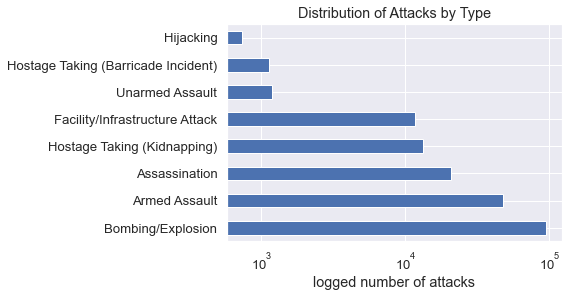

In [37]:
#Plot distribution of target class
ax = gtd.attacktype1_txt.value_counts().plot(kind='barh')
ax.set_xscale('log')
ax.set_xlabel("logged number of attacks")
ax.set_title("Distribution of Attacks by Type")
n_types = len(gtd["attacktype1"].value_counts())
print(f"There are {n_types} types of attacks terrorists carry out")
gtd["attacktype1_txt"].value_counts()

We can see that the majority of attacks carried out by terrorists are bombings whilst hijackings are the least common types of attacks. The dataset is heavily unbalanced and this is something we will have to adjust for in our machine learning model.

## 1.2 Data Cleaning

### Create Additional Columns

I reformat some of my columns to capture relevant information. 

1. Instead of having the start and end dates for a conflict, I calculate the duration between dates whilst also keeping the start date. This is because the duration of an attack captures the information between these two columns better than just the start or end date.

2. Instead of having a "related" column with a string listing the related terrorist attacks, I count the number of related attacks. E.g "attack1; attack2; attack3" becomes 3.

3. I replace several columns with -9, 0, 1 labels to Unknown, No and Yes respectively. The entries in this column do not have an order to them so it is more helpful to turn them into strings for one hot encoding.

4. Some numerical columns use either -99 or -9 to denote unknown values. I change both of these to -1 since thse columns do not contain negative values. -1 now indicates the presence of unknowns.

These feature names might be confusing but I provide a detailed description in the next few cells.

In [6]:
#convert resolution to a datetime format
gtd["resolution"] = pd.to_datetime(gtd["resolution"], format="%d/%m/%Y")

#we convert our datetime values to get a sense of the duration of conflicts
gtd["duration"] = gtd.apply (lambda row: util.duration_calculator(row), axis=1)

#for these variables we convert the categorical numerical into a categorical string variable
gtd["doubtterr"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "doubtterr"), axis=1)
gtd["compclaim"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "compclaim"), axis=1)
gtd["claimed"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "claimed"), axis=1)
gtd["claim2"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "claim2"), axis=1)
gtd["claim3"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "claim3"), axis=1)
gtd["property"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "property"), axis=1)
gtd["ishostkid"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "ishostkid"), axis=1)
gtd["ransom"] = gtd.apply(lambda row: util.num_to_string_encoder(row, "ransom"), axis=1)

#for the related column we count the number of incidents
gtd["related"] = gtd.apply(lambda row: util.text_counter(row, "related"), axis=1)

#Replace any remaining negative numbers that denote "Unknown" values with -1
gtd = gtd.replace([-99.0, -9], -1)

### Drop unnecessary columns

Next I drop all unnecessary columns. These columns fall into one of two categories:

1. Columns with unique values for each row
2. Columns that already have information captured in other columns. For example, claimmode and claimmode_txt are numerical and string encodings of the same information. I keep the more appropriate column and drop the other to avoid duplicates. If there is an order to the data I keep the numbered encodings, otherwise I keep the text for one hot encoding.

Here is a full list with justifications:
 - eventid: unique id for each event
 - approxdate: approximate date each event started (already captured in year/month/day columns)
 - resolution: data the incident was resolved. Already captured in my duration column that indicates how long attacks lasted since start date.
 - summary: text column containing descriptions of the attack. This will contain information on the type of attack so I remove it.
 - country: country codes I remove in favor of country_txt
 - location: unique value for each column (e.g. "a street corner on 625 w jackson boulevard")
 - attacktype columns since these contain text descriptions of the attack type. Also since I am only predicting the main attacktype, I remove attacktype2 and attacktyp3.
 - weaptype columns containing type of weapons used. I discard the numerical in favor of the categorical weaptype_txt
 - same for weapsubtype
 - weapdetail: unique descriptions for each weapon
 - targtype columns: Describes the target that was attacked. I discard numerical and keep categorical targtype_txt columns
 - same for targsubtype: describes the sub target of the target type identified.
 - claimmode: How terrorists claimed responsibility for attacks. I use the categorical claimmode_txt instead.
 - motive: unique motivations for each attack
 - propextent_txt: category for extent of property damge. The numerically encoded propextent makes more sense since there are varying degrees of property damage.
 - propcomment: unique descriptions for property damages.
 - divert: unique descriptions for hostage taking.
 - ransomenote: unique descriptions for ransom notes received
 - hostkidoutcome: outcome of kidnappings. discarded in favour of categorical hostkidoutcome_txt.
 - natlty: nationality of perpetrators. discarded in favour of categorical natlty_txt.
 - provstate, city, corp1, corp2, corp3, city all contain unique values.
 - target1, target2, target3: unique descriptions for each target (e.g. "US embassy building in New York")

In [7]:
gtd_drop = gtd.drop(columns=["eventid", "approxdate", "resolution", "summary", "alternative", "country",
                             "location", "attacktype1_txt", "attacktype2", "attacktype3", "attacktype2_txt",
                             "weaptype1", "weaptype2", "weaptype3", "weaptype4", "weapsubtype1", "weapsubtype2",
                             "weapsubtype3", "weapsubtype4", "weapdetail", "targtype1", "targtype2",
                             "targtype3", "targsubtype1", "targsubtype2", "targsubtype3", "claimmode", 
                             "claimmode2", "claimmode3", "motive", "propextent_txt", "propcomment", "divert",
                             "ransomnote", "hostkidoutcome", "addnotes", "scite1", "scite2", "scite3", "dbsource",
                             "natlty1", "natlty2", "natlty3", "provstate", "city", "corp1", "corp2", "corp3", 
                             "target1", "target2", "target3", "city","attacktype3_txt", "region"])

In [8]:
gtd_drop.head()

,iyear,imonth,iday,extended,country_txt,region_txt,latitude,longitude,specificity,vicinity,...,ransompaid,ransompaidus,hostkidoutcome_txt,nreleased,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,duration
0,1970,7,2,0,Dominican Republic,Central America & Caribbean,18.456792,-69.951164,1.0,0,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0.0
1,1970,0,0,0,Mexico,North America,19.371887,-99.086624,1.0,0,...,NaN,NaN,NaN,NaN,0,1,1,1,0,0.0
2,1970,1,0,0,Philippines,Southeast Asia,15.478598,120.599741,4.0,0,...,NaN,NaN,NaN,NaN,-1,-1,1,1,0,0.0
3,1970,1,0,0,Greece,Western Europe,37.997490,23.762728,1.0,0,...,NaN,NaN,NaN,NaN,-1,-1,1,1,0,0.0
4,1970,1,0,0,Japan,East Asia,33.580412,130.396361,1.0,0,...,NaN,NaN,NaN,NaN,-1,-1,1,1,0,0.0


In [9]:
gtd_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191593 entries, 0 to 201182
Data columns (total 83 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   iyear               191593 non-null  int64  
 1   imonth              191593 non-null  int64  
 2   iday                191593 non-null  int64  
 3   extended            191593 non-null  int64  
 4   country_txt         191593 non-null  object 
 5   region_txt          191593 non-null  object 
 6   latitude            187328 non-null  float64
 7   longitude           187327 non-null  float64
 8   specificity         191592 non-null  float64
 9   vicinity            191593 non-null  int64  
 10  crit1               191593 non-null  int64  
 11  crit2               191593 non-null  int64  
 12  crit3               191593 non-null  int64  
 13  doubtterr           191593 non-null  object 
 14  alternative_txt     29944 non-null   object 
 15  multiple            191593 non-nul

My final dataframe has 84 columns, 39 are categorical, 26 are numeric continuous and 18 are numeric categorical.

Full descriptions can be found in the codebook and also here:

 - iyear, imonth, iday: year, month and day
 - extended: did incident last more than 1 day?
 - country_txt: name of country incident occurred in.
 - region_txt: name of region incident occurred in.
 - latitude, longitude of incident
 - specificity: how certain are we of the location of attack
 - vicinity: did the attack occur near a city
 - crit1: did the attack have a political, economic, or social goal?
 - crit2: was there an intent to intimidate or coerce a larger audience?
 - crit3: did the incident violate international humanitarian law?
 - doubtterr: is there any doubt that this was a terrorist attack?
 - alternative_txt: if there is doubt, what could the alternative be? (e.g. crime)
 - multiple: is this a part of multiple incidents
 - success: did the attackers succeed?
 - suicide: was suicide terrorism involved?
 - attacktype1: type of attack (target column)
 - targtype, targsubtype: the type of target and sub-target (e.g. "government building", "millitary base")
 - natlty: nationality of perpetrators
 - gname, gsubname: name of groups and sub-groups involved (e.g. "Hezbollah", "Al-Qaeda")
 - guncertain: is there uncertainty over which group was involved?
 - individual: were individuals unaffiliated with the identified group involved?
 - nperps, nperpscap: number of terrorists involved and captured
 - claimed, claimmode: was there a claim of responsibility? If so, how was the claim mode? (e.g. phone call)
 - weaptyp, weapsubtype: type and subtype of weapon used
 - nkill, nkillus, nkillter: number killed, number of americans killed, number of terrorists killed
 - nwound, nwoundus, nwoundter: same as above but for wounded
 - property, propextent, propvalue: was there property damage? to what extent? what is the dollar value?
 - ishostkid, nhostkid, nhostkidus: were hostages taken or did kidnapping occur? how many? how many from the US?
 - nhours, ndays: how long did the hostage situation or kidnapping last?
 - kidhijcountry: which country was the hostage taking or kidnapping incident resolved in?
 - ransom, ransomamt, ransomamtus, ransompaid, randsompaidus: was a ransom asked for? how much? how much in usd? how much was paid? how much was paid in usd?
 - hostkidoutcome_txt: what was the outcome of the hostage taking/kidnapping?
 - nreleased: how many were released?
 - INT_LOG: did terrorists cross a border to carry out attack?
 - INT_IDEO: was the nationality of the terrorists differ from the nationality of the target?
 - INT_MISC: was the nationality of the terrorists differ from the nationality of the victim?
 - INT_ANY: was it completely international on the above three features?
 - related: number of related incidents
 - duratioon: how long did incident last
 
Note: I include the kidnapping/hostage taking columns because sometimes groups do not intend to take hostages. For example, in an armed assault gone wrong, hostages might be taken as a last minute gambit. These columns help differentiate between these cases and explicit kidnappings etc.

### Fill NA values, perform onehot encoding and scale

Now I use sklearn pipes and preprocessing methods to fill in na values for numerical features and perform one hot encoding on categorical features. Beside each column containing an na value, we create another column encoding the presence of na values so that our classifier can differentiate between cells with NA values and cells without.

I scale all my columns to a (0, 1) range. This will allow for smoother implementation using stochastic averge gradient with the Logistic Regression.

I also add parameter sparse=True during one-hot encoding so that my resultant numpy array does not take up too much memory.

In [10]:
#Separate data into predictor and outcome
X = gtd_drop.drop("attacktype1", axis=1)
y = gtd_drop.attacktype1

#Seperate numerical ordinal, numerical continuous and categorical features
numerical_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
numerical_continuous = ["ransompaid", "ransompaidus", "nreleased", "nperps",
                        "nperpcap", "nkill", "nkillus", "nkillter", "nwound",
                        "nwoundus", "nwoundte", "propvalue", "nhostkid", "nhostkidus",
                        "ransomamt", 'ransomamtus', 'ransompaid', 'ransompaidus', 
                        'nreleased', "related", "duration"]
numerical_ordinal = [feature for feature in numerical_features if feature not in numerical_continuous]

#create pipelines for feature representation

#for continuous features we fill na with 0
numconti_pipeline = Pipeline(steps=[("scale", MinMaxScaler()),
                                    ("fillna", SimpleImputer(missing_values=np.nan,
                                                              strategy="constant",
                                                              fill_value=0,
                                                              add_indicator=True))])

#for ordinal features we fill na with -1, same as for values that are unknown
numord_pipeline = Pipeline(steps=[("scale", MinMaxScaler()),
                                    ("fillna", SimpleImputer(missing_values=np.nan,
                                                              strategy="constant",
                                                              fill_value=-1,
                                                              add_indicator=True))])

#for categorical features we fillna and perform one hot encoding
categorical_pipeline = Pipeline(steps=[("fillna", SimpleImputer(missing_values=np.nan,
                                                                strategy="constant",
                                                                fill_value="None",
                                                                add_indicator=True)),
                                        ('one-hot', OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=True))])

#integrate both pipelines
full_processor = ColumnTransformer(transformers=[
    ("numconti", numconti_pipeline, numerical_continuous),
    ("numord", numord_pipeline, numerical_ordinal),
    ('category', categorical_pipeline, categorical_features)
])

#perform feature representation on all X
X = full_processor.fit_transform(X)

In [11]:
X.shape

(191593, 7136)

Our end dataframe has 7136 features we can use to predict the target class.

## 1.4 Train, Test Split

I don't want to use the preprocessed matrix X in my model. Instead, I want to create a unified pipeline that will preprocess and train the model. Thus, I reset my X and y. 

Additionally, I only want to fit my preprocessor on the training data and only transform the testing data. The aim is to not have any information leakage.

In [12]:
X = gtd_drop.drop("attacktype1", axis=1)
y = gtd_drop.attacktype1

I split my data into training and testing sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Text(0.5, 1.0, 'Distribution of Attack Types in Training Data')

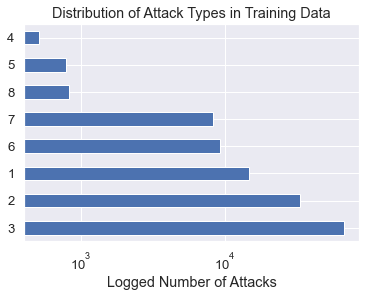

In [96]:
#Plot distribution of target class
ax = y_train.value_counts().plot(kind='barh')
ax.set_xscale("log")
ax.set_xlabel("Logged Number of Attacks")
ax.set_title("Distribution of Attack Types in Training Data")

The distribution of target classes in my training dataset is largely similar to the full dataframe.

# Part 2: Model Training & Evaluation

## 2.1 Model Selection

I will be implementing the following models

1. Random Forest Classifier
2. Logistic Regression using Stochastic Average Gradient
3. Linear SVM

## 2.2 Parameter Tuning, Validation and Testing

To identify the best combination of parameters for my random forest I run a grid search using different inputs. My grid search here is a randomized grid search that will pick 10 combinations of parameters randomly. This saves time and computing power.

The metric I use for evaluation is the f1_weighted score. In the case of attack types, both precision and recall are equally important. For example, if the model predicts a hijacking and it turns out to be a false positive, unnecessary resources are spent preparing for the wrong type of attack. This preparation might be inappropriate for the true attack type which will lead to potentially more death. On the other hand, if the model predicts it will not be a hijacking and it ends up being hijacking, lives will be lost as well.

I choose a weighted f1 to get a weighted average of all f1 scores since my dataset is unbalanced.

### Random Forest Classifier

In my Random Forest Classifier, I set class_weight to balanced to weight each target class inversely to its frequency. Additionally, I set n_jobs=-1 to use all of my CPU cores. There are many potential combinations for my grid search so I use a RandomizedSearcbCV that will randomly select a number of combination to execute as specified by n_iter.

I set cv=5 for 5-fold cross validation. The total number of fits is 50.

In [50]:
rf = RandomForestClassifier(verbose=3.0,
                            random_state=1235,
                            class_weight="balanced",
                            n_jobs=-1)

#I can integrate my preprocessor with my estimator
rf_pipe = Pipeline(steps=[("preproc", full_processor),
                          ('clf', rf)],
                   verbose=True)

#parameter dictionary for grid search
param_dict = {"clf__criterion": ["gini", "entropy"],
              "clf__n_estimators": [100],
              "clf__max_depth": [40, 50],
              "clf__min_samples_split": [2, 4],
              "clf__min_samples_leaf": [1, 2, 4],
              "clf__max_leaf_nodes": [50000, 75000, 100000]}

search = RandomizedSearchCV(rf_pipe,
                            param_dict,
                            n_iter=10,
                            cv=5, 
                            scoring="f1_weighted",
                            n_jobs=-1,
                            verbose=3.0)
#execute search
rf_search = search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Pipeline] ........... (step 1 of 2) Processing preproc, total=   3.3s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.1s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


#### Best parameters and f1-score

In [97]:
print('Best weighted f1:', abs(rf_search.best_score_))
print('Best params:', rf_search.best_params_)

Best weighted f1: 0.9307385452783059
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 1, 'clf__max_leaf_nodes': 75000, 'clf__max_depth': 50, 'clf__criterion': 'gini'}


#### Final RF

In [22]:
#fit final decision tree based on tuned hyperparameters
rf = RandomForestClassifier(verbose=3.0,
                            n_estimators = 100,
                            min_samples_split=4,
                            min_samples_leaf=1,
                            max_leaf_nodes=75000,
                            max_depth=50,
                            criterion="gini",
                            random_state=1234,
                            class_weight="balanced",
                            n_jobs=-1)

final_rf_pipe = Pipeline(steps=[("preproc", full_processor),
                                ('clf', rf)],
                         verbose=True)

rf_final = final_rf_pipe.fit(X_train, y_train)
y_preds_rf = final_rf_pipe.predict(X_test)

[Pipeline] ........... (step 1 of 2) Processing preproc, total=   2.6s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100

building tree 5 of 100

building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100building tree 11 of 100

building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.5s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.1min


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


### Logistic Regression with Stochastic Average Gradient.

Next I move on to logistic regression. I use the "l2" penalty with "sag" and "l1" penalty with "saga". By testing both l1 and l2 penalties I can also perform and compare outcomes with/without feature selection.

I set mult_class to "ovr" for a one-vs-rest model that should require less computational power. I want to use stochastic average gradient to minimise the target function, hence I choose "sag"/"saga". According to sklearn, "sag" and "saga" should converge faster for large datasets with > 100,000 samples. However, this is contingent on all features having the same scale. Thankfully, I used MinMaxScaler during my pre-processing.

My values of C during my grid search are set <= 1.0 to avoid overfitting.

In [14]:
logR = LogisticRegression(max_iter=100,
                          dual=False,
                          class_weight="balanced",
                          multi_class="ovr",
                          random_state=12346,
                          n_jobs=-1,
                          verbose=3.0)

logR_pipe = Pipeline(steps=[("preprocess", full_processor),
                            ("clf", logR)],
                     verbose=True)

param_grid = [{"clf__solver": ["sag"],
               "clf__penalty": ["l2"],
               "clf__C": [0.01, 0.1, 1.0]},
              {"clf__solver": ["saga"],
               "clf__penalty": ["l1"],
               "clf__C": [0.01, 0.1, 1.0]}]

search = GridSearchCV(logR_pipe,
                      param_grid,
                      cv=5, 
                      scoring='f1_weighted',
                      n_jobs=-1,
                      verbose=3.0)

logR_search = search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   2.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 72 seconds


C:\Users\thiya\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 75 seconds
max_iter reached after 76 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.3min remaining:  2.1min


max_iter reached after 91 seconds
max_iter reached after 93 seconds
max_iter reached after 94 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  1.6min remaining:   31.3s


max_iter reached after 105 seconds
max_iter reached after 113 seconds
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.9min


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.9min finished


The model did not successfully converge on all iterations. However, increasing this value during my grid search will require a lot of computational power.

#### Best parameters and f1-score

In [15]:
print('Best weighted f1:', abs(logR_search.best_score_))
print('Best params:', logR_search.best_params_)

Best weighted f1: 0.8751042573952373
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'saga'}


#### Final Logistic Regression

In [16]:
#fit final Logistic Regression Model
logR = LogisticRegression(C=1.0,
                          penalty="l1",
                          solver="saga",
                          max_iter=100,
                          dual=False,
                          class_weight="balanced",
                          multi_class="ovr",
                          random_state=12346,
                          n_jobs=-1,
                          verbose=3.0)

final_logR_pipe = Pipeline(steps=[("preprocess", full_processor),
                                  ("clf", logR)],
                           verbose=True)

logR_final = final_logR_pipe.fit(X_train, y_train)
y_preds_logR = final_logR_pipe.predict(X_test)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   2.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 66 seconds


C:\Users\thiya\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 69 seconds
max_iter reached after 70 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  1.2min remaining:  2.0min


max_iter reached after 85 seconds
max_iter reached after 87 seconds
max_iter reached after 89 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  1.5min remaining:   29.6s


max_iter reached after 99 seconds
max_iter reached after 106 seconds
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.8min finished


Unfortunately we still have a failure to converge. One solution would be to increase the number of iterations even further but that will be computationally intensive.

### Support Vector Machine with Linear Kernel

I next move on to my implementation of support vector machines. For my grid search I compare "l1" and "l2" penalties and set a series of C values, taking care to not set C > 1.0 to avoid overfitting. 

By testing both l1 and l2 penalties I can also perform and compare outcomes with/without feature selection.

In [17]:
#svm
svm = LinearSVC(dual=False,
                multi_class="ovr",
                class_weight="balanced",
                verbose=3.0,
                random_state=12347)

svm_pipe = Pipeline(steps=[("preprocess", full_processor),
                           ("clf", svm)],
                           verbose=True)

param_grid = [{"clf__loss": ["squared_hinge"],
               "clf__penalty": ["l2"],
               "clf__C": [0.01, 0.1, 1.0]},
              {"clf__loss": ["squared_hinge"],
               "clf__penalty": ["l1"],
               "clf__C": [0.01, 0.1, 1.0]}]

search = GridSearchCV(svm_pipe,
                      param_grid,
                      cv=5, 
                      scoring="f1_weighted",
                      n_jobs=-1,
                      verbose=3.0)

svm_search = search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   2.7s
[LibLinear][Pipeline] ............... (step 2 of 2) Processing clf, total=  34.3s


#### Best parameters and f1-score

In [18]:
print('Best weighted f1:', abs(svm_search.best_score_))
print('Best params:', svm_search.best_params_)

Best weighted f1: 0.9125733440007782
Best params: {'clf__C': 0.1, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2'}


Overall it looks like my Random Forest returned the best score after grid search.

#### Final SVM Model

In [28]:
#fit final svm Model
svm = LinearSVC(penalty="l2",
                loss="squared_hinge",
                C = 0.1,
                dual=False,
                multi_class="ovr",
                class_weight="balanced",
                verbose=2.0,
                random_state=12347)

final_svm_pipe = Pipeline(steps=[("preprocess", full_processor),
                                 ("clf", svm)],
                          verbose=True)

svm_final = final_svm_pipe.fit(X_train, y_train)
y_preds_svm = final_svm_pipe.predict(X_test)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   2.7s
[LibLinear][Pipeline] ............... (step 2 of 2) Processing clf, total=  35.1s


Now that I have fit all of my models. I can move on to evaluating their performance on the test set.

## 2.3 Model Performance

To compare the results from my models, I build classification accuracy tables for each model.

### Random Forest Classification

In [23]:
print(classification_report(y_test,
                            y_preds_rf,
                            target_names=target_names))

                                precision    recall  f1-score   support

                 Assassination       0.88      0.73      0.79      6276
                 Armed Assault       0.90      0.92      0.91     14165
             Bombing/Explosion       0.97      0.99      0.98     28803
                     Hijacking       0.90      0.41      0.56       222
            Barricade Incident       0.61      0.60      0.61       341
                    Kidnapping       0.90      0.96      0.93      3931
Facility/Infrastructure Attack       0.84      0.90      0.87      3376
               Unarmed Assault       0.87      0.82      0.84       364

                      accuracy                           0.93     57478
                     macro avg       0.86      0.79      0.81     57478
                  weighted avg       0.93      0.93      0.93     57478



The weighted average of the random forest's precision is 0.93, meaning that when it makes a prediction, it has a 93% chance of being correct. The recall is also 0.93 meaning that 93% of each target type is correctly classified. 

The classifier is the mist successful at identifying Bombings, Kidnappings and Armed Assaults whilst performing the worst on Barricade Incidents (hostage taking where the hostages are barricaded indoors), Hijackings and Assassinations. I can see that the classifier tends to perform worse on target classes with the least data.

Of particular concern is the very low recall for Barricade incidents, meaning that only 41% of this type of Hostage Taking has been correctly identified. However, the precision for this incident is high, indicating that when the model predicts a barricade it is correct about 90% of the time.

Overall, the results are promising and the random forest classifier gives me a useful baseline with which I can benchmark my other models against.

### Logistic Regression with Stochastic Average Gradient.

In [19]:
print(classification_report(y_test,
                            y_preds_logR,
                            target_names=target_names))

                                precision    recall  f1-score   support

                 Assassination       0.75      0.76      0.75      6276
                 Armed Assault       0.91      0.80      0.85     14165
             Bombing/Explosion       0.98      0.96      0.97     28803
                     Hijacking       0.28      0.64      0.39       222
            Barricade Incident       0.13      0.89      0.23       341
                    Kidnapping       0.94      0.76      0.84      3931
Facility/Infrastructure Attack       0.75      0.87      0.81      3376
               Unarmed Assault       0.61      0.99      0.75       364

                      accuracy                           0.88     57478
                     macro avg       0.67      0.83      0.70     57478
                  weighted avg       0.91      0.88      0.89     57478



My logistic regression has a slightly lower weighted f1 score of 0.89. The 0.88 recall means that it accurately identified 88% of the target classes. However, the precision of the logistic regression is higher at 0.91, giving it a 91% chance of being correct when it makes a prediction.

The logistic regression is strongest at predicting bombings, armed assaults and kidnappings. It performs the worst at predicting hijackings, barricade incidents and assassinations. Of particular concern are barricade incidents, with a very high false negative rate. All three target classes have smaller sample sizes compared to the most frequent classes.

Interestingly, the model is fairly accurate at predicting facility/infrastructure attacks despite the small sample size. There must be some features strongly correlated with these attacks to allow for the strong performance.

Overall, the results here are less promising than for the random forest classifier.

### Support Vector Machine with Linear Kernel

In [29]:
print(classification_report(y_test,
                            y_preds_svm,
                            target_names=target_names))

                                precision    recall  f1-score   support

                 Assassination       0.77      0.75      0.76      6276
                 Armed Assault       0.90      0.86      0.88     14165
             Bombing/Explosion       0.98      0.97      0.98     28803
                     Hijacking       0.49      0.59      0.53       222
            Barricade Incident       0.43      0.68      0.53       341
                    Kidnapping       0.92      0.94      0.93      3931
Facility/Infrastructure Attack       0.78      0.88      0.83      3376
               Unarmed Assault       0.80      0.96      0.87       364

                      accuracy                           0.91     57478
                     macro avg       0.76      0.83      0.79     57478
                  weighted avg       0.91      0.91      0.91     57478



The SVM classifier using a linear kernel returns a high weighted f1, precision, and recall. Similar to the other classifiers, it performs better as the sample size of the target class increases. 

The model is best at classifying bombings, kidnappings and armed assaults. It performs the worst with hijackings, barricade incidents and assassinations. All models seem to have trouble with barricade incidents and hijackings, which is likely due to the small sample size.

The results here are promising as well, leaving the SVM and RF as good choices out of the 3 models.

# Part 3: Results Analysis

## 3.1 Error Analysis

Instead of visualizing a massive decision tree, and generating other unique visualizations for each model, I plot confusion matrices for all classifiers to get a sense of where errors are happening.

### Random Forest

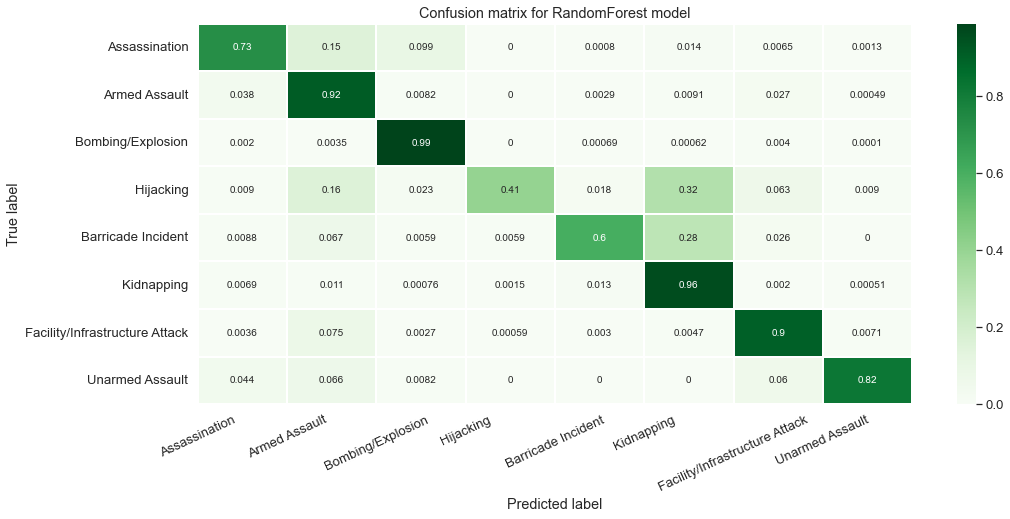

In [30]:
#Confusion Matrix for Random Forest Model
util.con_matrix(y_test, y_preds_rf, "RandomForest", target_names)

The random forest makes the following mistakes:

- Misclassifying 15% of assassinations as armed assaults
- Misclassifying 16% and 32% of hijackings as armed assaults and kidnapping respectively.
- Misclassifying 28% of barricade incidents as kidnapping.

This is probably due to the fact that hijackings, assassinations, barricade incidents and kidnappings are attacks that specifically target a small number of people. Thus, there should be significant overlap in the types of weapons used and the types of targets.

### Logistic Regression with Stochastic Average Gradient

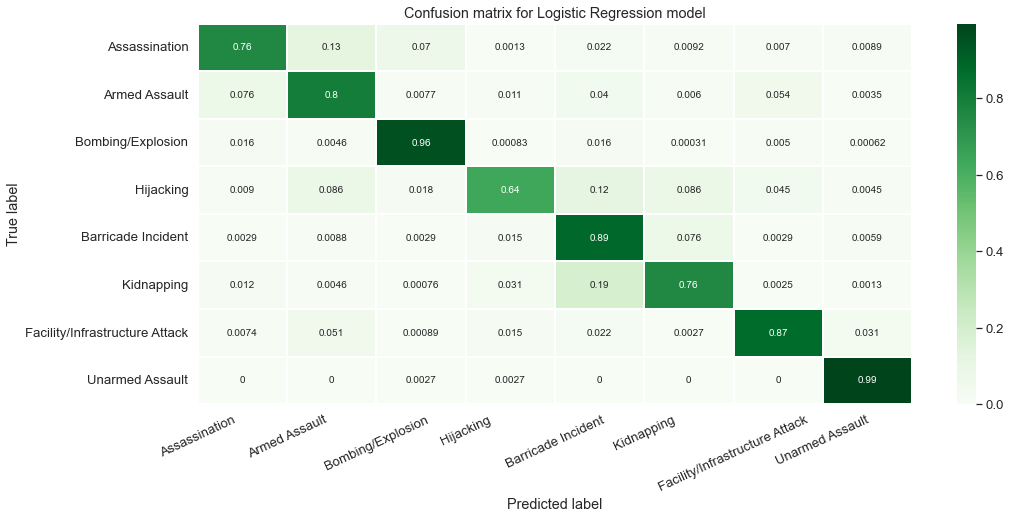

In [20]:
util.con_matrix(y_test, y_preds_logR, "Logistic Regression", target_names)

The logistic regression makes the following mistakes:

- Misclassifying 13% of assassinations as armed assaults
- Misclassifying 12% of armed assaults as barricade incidents.
- Misclassifying 19% of kidnappings as barricade incidents

Once again, this is probably due to the fact that hijackings, barricade incidents and kidnappings are attacks that specifically target a small number of people. Thus, there should be significant overlap in the types of weapons used and the types of targets.

The armed assault errors are harder to interpret and could be due to the fact that armed assaults occasionally end up in barricade incidents when the attackers fail and take hostages as a last resort.

### Support Vector Machine with Linear Kernel

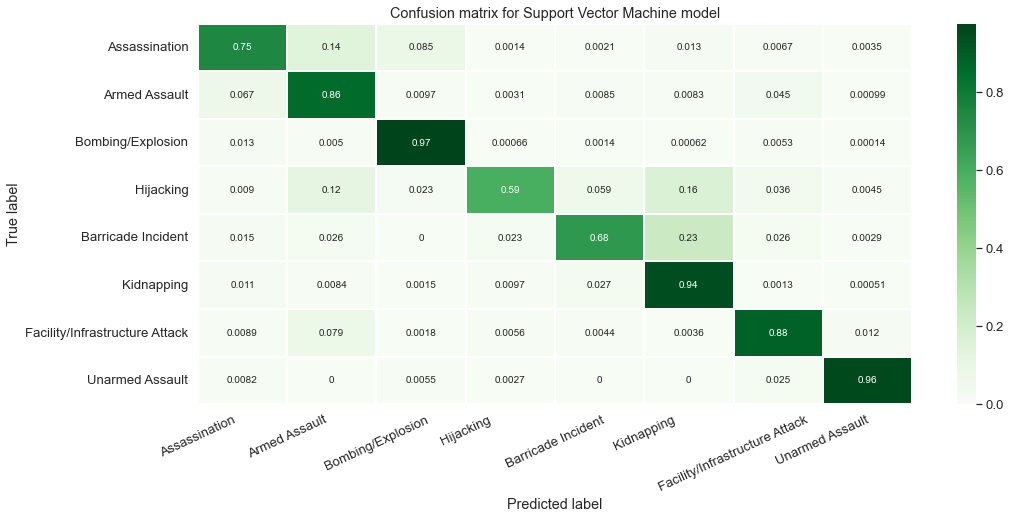

In [32]:
util.con_matrix(y_test, y_preds_svm, "Support Vector Machine", target_names)

The logistic regression makes the following mistakes:

- Misclassifying 14% of assassinations as armed assaults
- Misclassifying 12% and 16% of hijackings as armed assaults and kidnapping respectively.

Interestingly, the misclassifications for the support vector machine have a much smaller magnitude and are distributed more evenly across the various classes. The major errors could be due to commonalities between armed assaults, kidnappings, hijackings and assassinations such as a focus on human targets and military vehicles.

## 3.2 Top Coefficients

### Random Forest Classifier

In [33]:
feature_importance = FeatureImportance(final_rf_pipe)
for idx, target in enumerate(target_names):
    feature_list = list(zip(final_logR_pipe.named_steps["clf"].coef_[idx],
                            feature_importance.get_feature_names()))
    feature_list.sort(key = lambda x: x[0], reverse=True)
print(f"The 10 most important features in the Random Forest are:")
print("\n")
c = 0

for wt, feature in feature_list:
    if c < 10:
        if feature.startswith("x"):
            colnum = int(re.search(r"\d+", feature)[0])
            colname = categorical_features[colnum]
            colsubname = re.search(r"(?<=_).*", feature)[0]
            print(f"{colname} {colsubname} with a weight of {wt:.3f}")
        else:
            print(f"{feature} with a weight of {wt:.3f}")
        c += 1

The 10 most important features in the Random Forest are:


weaptype1_txt Melee with a weight of 90.235
weaptype1_txt Chemical with a weight of 86.305
weapsubtype1_txt Blunt Object with a weight of 79.209
weaptype1_txt Other with a weight of 73.076
weaptype2_txt Melee with a weight of 63.417
weaptype1_txt Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs) with a weight of 57.866
weapsubtype1_txt Hands, Feet, Fists with a weight of 57.613
weapsubtype2_txt Unknown Weapon Type with a weight of 47.785
weaptype1_txt Biological with a weight of 47.452
weapsubtype1_txt Poisoning with a weight of 44.337


C:\Users\thiya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The random forest classifier gives the most weight to weapon types, and this makes sense. For example Hands, Feet, Fists are most likely correlated with an unarmed assault. Complications are likely to arrise from attacks that use a weapon type associated with different types of attacks. For example, vehicles might be used for both bombings and armed assaults.

### Logistic Regression

In [23]:
feature_importance = FeatureImportance(final_logR_pipe)
#logisticregression
for idx, target in enumerate(target_names):
    feature_list = list(zip(final_logR_pipe.named_steps["clf"].coef_[idx],
                            feature_importance.get_feature_names()))
    feature_list.sort(key = lambda x: x[0], reverse=True)
    print(f"The 3 most important features in the Logistic Regression for {target} are:")
    for wt, feature in feature_list[0:3]:
        if feature.startswith("x"):
            colnum = int(re.search(r"\d+", feature)[0])
            colname = categorical_features[colnum]
            colsubname = re.search(r"(?<=_).*", feature)[0]
            print(f"{colname} {colsubname} with a weight of {wt:.3f}")
        else:
            print(f"{feature} with a weight of {wt:.3f}")
    print("\n")

The 3 most important features in the Logistic Regression for Assassination are:
gname Black September with a weight of 6.712
kidhijcountry Nepal with a weight of 6.091
gsubname National Army for the Liberation of Uganda (NALU) with a weight of 5.629


The 3 most important features in the Logistic Regression for Armed Assault are:
weaptype1_txt Firearms with a weight of 6.026
weapsubtype1_txt Knife or Other Sharp Object with a weight of 4.960
nkill with a weight of 4.925


The 3 most important features in the Logistic Regression for Bombing/Explosion are:
weaptype1_txt Explosives with a weight of 7.093
gsubname Meinhof Anti-Imperialist Group with a weight of 6.342
weapsubtype1_txt Explosive with a weight of 5.799


The 3 most important features in the Logistic Regression for Hijacking are:
targsubtype1_txt Aircraft (not at an airport) with a weight of 212.975
targsubtype1_txt Vehicles/Transportation with a weight of 208.585
targtype1_txt Airports & Aircraft with a weight of 161.432


Th

The logistic regression gives the strongest weights to weapon types, target types and group names across all target classes. Understanding if these coefficients make sense requires contextual knowledge. For example, knowing whether Ku Klux Klan members carry out a large number of kidnappings will help determine if its heavy weighting is justified for the kidnapping class.

Some weights do not make sense. For example, hands and feet as weapon types are heavily weighted for barricade incidents. It does not make sense to take hostages within a barricaded compound without more powerful weapons to defend yourself with.

### Support Vector Machine

In [35]:
feature_importance = FeatureImportance(final_svm_pipe)

for idx, target in enumerate(target_names):
    feature_list = list(zip(final_svm_pipe.named_steps["clf"].coef_[idx],
                            feature_importance.get_feature_names()))
    feature_list.sort(key = lambda x: x[0], reverse=True)
    print(f"The 3 most important features in the SVM for {target} are:")
    for wt, feature in feature_list[0:3]:
        if feature.startswith("x"):
            colnum = int(re.search(r"\d+", feature)[0])
            colname = categorical_features[colnum]
            colsubname = re.search(r"(?<=_).*", feature)[0]
            print(f"{colname} {colsubname} with a weight of {wt:.3f}")
        else:
            print(f"{feature} with a weight of {wt:.3f}")
    print("\n")

The 3 most important features in the SVM for Assassination are:
gname Black September with a weight of 1.174
gsubname South African Suicide Squad with a weight of 0.952
targtype1_txt Journalists & Media with a weight of 0.926


The 3 most important features in the SVM for Armed Assault are:
weaptype1_txt Firearms with a weight of 1.457
weapsubtype1_txt Knife or Other Sharp Object with a weight of 1.395
propextent_missing_flag with a weight of 1.259


The 3 most important features in the SVM for Bombing/Explosion are:
weaptype1_txt Explosives with a weight of 1.620
weaptype2_txt Explosives with a weight of 1.060
weapsubtype1_txt Explosive with a weight of 1.028


The 3 most important features in the SVM for Hijacking are:
gname Afghan Guerrillas with a weight of 2.419
gsubname Los Pelusos with a weight of 2.198
gname Revolutionary Armed Forces of Colombia (FARC) dissidents with a weight of 1.856


The 3 most important features in the SVM for Barricade Incident are:
natlty1_txt Panama wi

For the SVM, the heaviest weights are also given to weapon types, group names and target types. As mentioned previously, contextual knowledge can be helpful in determining if these weights are valid.

Once again, some feature weights do not make sense. For example, in predicting barricade incidents, the heaviest weight is given to the presence of panamanian terrorists. I am sure that different groups have all taken hostage before. It could be the case that of the few instances that panamanians have been involved in, the majority of them have been barricade incidents. Deeper contextual knowledge is required to evaluate this.

# Final Thoughts

From my analysis, I conclude that the random forest and svm are the most appropriate classifiers for this prediction task. The random forest classifier performs the strongest across the various statistical metrics. More importantly, its weighting of coefficients is logical and is heavily supported by the existing literature on terrorism. 

The SVM, whilst performing well in the classification table and confusion matrix, weights coefficients with little contextual validity occasionally. Although it is possible that the algorithm has identified hidden patterns in the data, the odds are unlikely. However, it is also worth noting that the svm makes less systemic errors and has its misclassifications more evenly distributed. This can make the model more useful in certain contexts.

The Logistic Regression is not far behind the two and would probably benefit more with a larget set of training data.

The authors of this paper only utilised a random forest model and based on my results I can see why. The random forest I have implemented here has also reached similar scores as the authors of the paper. Overall, I am satisfied with the performance of the model and am looking forward to deploying it for actual predictive tasks.